In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rc('font', family='DejaVu Sans')
import matplotlib.pyplot as plt

In [2]:
import sys
import json
import joblib
from pathlib import Path
from collections import defaultdict

import pandas as pd
from tqdm import tqdm, tqdm_notebook

sys.path.insert(0, '../deep-deep/')

In [26]:
results_dir = Path('../deep-deep/results/')

In [28]:
# def extract_params(results_dir):
#     for d in tqdm(results_dir.iterdir()):
#         try:
#             dct = joblib.load(str(d/'Q-1000.joblib'))
#             (d/'params.json').write_text(json.dumps(dct['_params']))
#         except FileNotFoundError as e:
#             print(e)
            
# extract_params(results_dir)

In [46]:
def read_result(folder):
    size = int(folder.name.split('-')[0][len('alexa'):])
#     meta = json.loads((folder/'meta.json').read_text())
    try:
        stats = pd.DataFrame([
            json.loads(line)
            for line in (folder/'stats.jl').read_text().splitlines()
        ])
        params = json.loads((folder/'params.json').read_text())
    except FileNotFoundError:
        return None
    params['input_size'] = size
    return stats, params

In [237]:
defaults = {
    'double': True,
    'use_urls': False,
    'gamma': 0.4,
    'eps': 0.2,
    'balancing_temperature': 1.0,
    'replay_sample_size': 300,
    'steps_before_switch': 100,
}

aliases = {
    'double': 'D',
    'use_urls': 'U',
    'gamma': 'γ',
    'eps': 'ε',
    'balancing_temperature': 'T',
    'replay_sample_size': 'repl',
    'steps_before_switch': 'step',
}

def param_str(params):
    p = params.copy()
    res = [
        "domains={input_size}".format(**p),        
    ]    
    for name in ['gamma', 'eps', 'balancing_temperature', 
                 'replay_sample_size', 'steps_before_switch', 
                 'double', 'use_urls']:
        if p[name] != defaults.get(name):
            alias = aliases.get(name, name)
            res.append("{}={}".format(alias, p[name]))
    
    return " ".join(res)
        
#     p['D'] = '+D' if p['double'] else '-D'
#     p['U'] = '+U' if p['use_urls'] else '-U'
#     return ("{input_size} γ={gamma:0.2f} ε={eps:0.2f} "
#            "T={balancing_temperature:0.1f} repl={replay_sample_size} step={steps_before_switch} " 
#            "{D} {U}").format(**p)

In [238]:
%%time
results = [read_result(folder) for folder in (results_dir.iterdir())]
results = [r for r in results if r is not None]
results_500 = [r for r in results if r[1]['input_size'] == 500]
results_100 = [r for r in results if r[1]['input_size'] != 500]

print(len(results))

79
CPU times: user 8.09 s, sys: 56 ms, total: 8.14 s
Wall time: 8.14 s


In [239]:
def get_groups(results):
    groups = defaultdict(list)
    for stats, params in results:
        groups[param_str(params)].append(stats)
    return dict(groups)
        
groups_100 = get_groups(results_100)
groups_500 = get_groups(results_500)

### Questions

1. Are patterns the same for 100 and 500 domains?
2. How does eps=0 affect crawling?
3. How does gamma=0 affect crawling? What about other gamma values?
4. How does double learning affect crawling?
5. How does domain balancing temperature affect crawling?
6. How many examples to take for training from experience replay memory?
7. How often to update priorities for all requests?

### Observations

1. with eps=0 crawler still works; it works better at beginning, but top results are
2. gamma=0 works OK for 

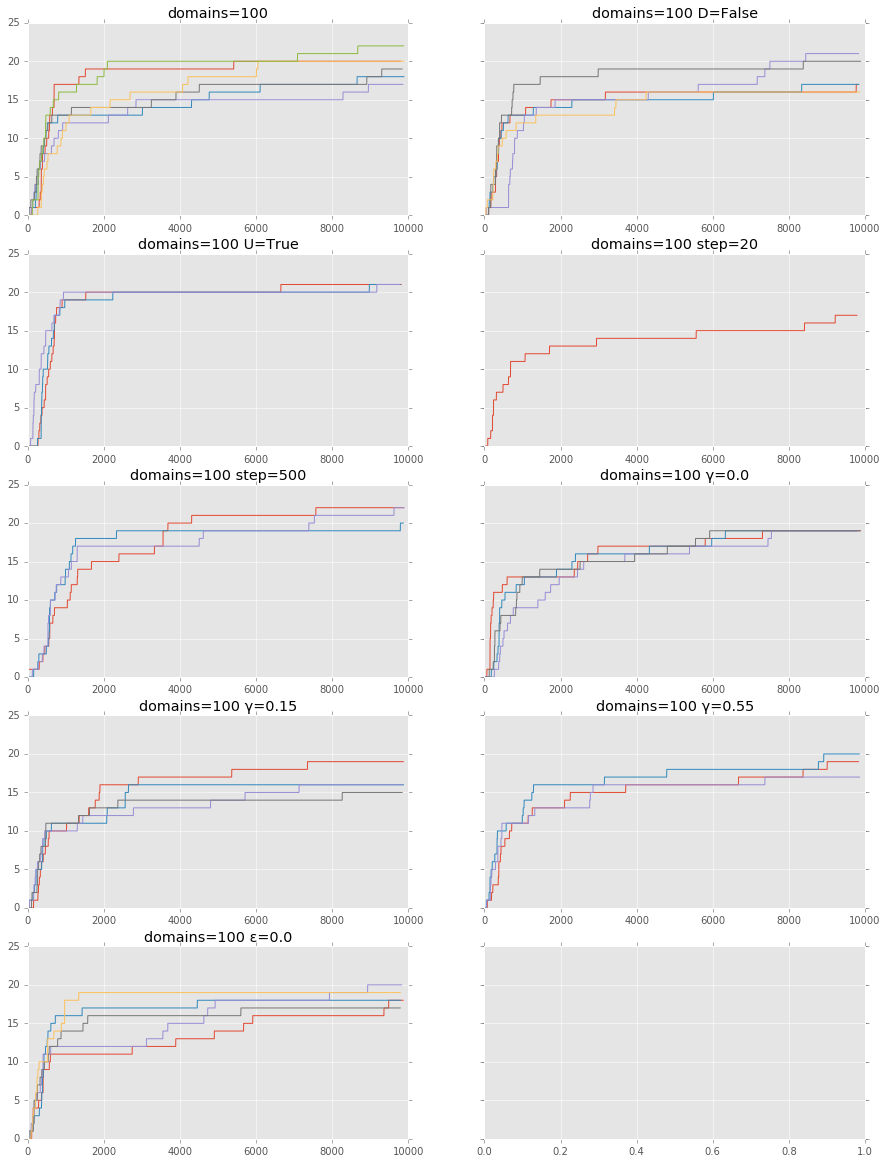

In [240]:
def plot_all(groups, max_y, max_x=9500):
    
    fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(15, 20))
    
    for idx, (key, trails) in enumerate(sorted(groups.items())):
        plt.figure()
        df = pd.concat([s.domains_closed for s in trails], axis=1)
        df.plot(
            sharey=True,
            ax=axes[idx // 2, idx % 2],
            title=key, 
            ylim=(0, max_y), 
            xlim=(0, max_x),
            legend=None,            
        )
#         for s in trails:
#             s.domains_closed.plot(
#                 ax=axes[idx // 2, idx % 2],
#                 title=key, 
#                 ylim=(0, max_y), 
#                 xlim=(0, max_x),
# #                 figsize=(6,4), 
#             )
            
plot_all(groups_100, 25, 10000)

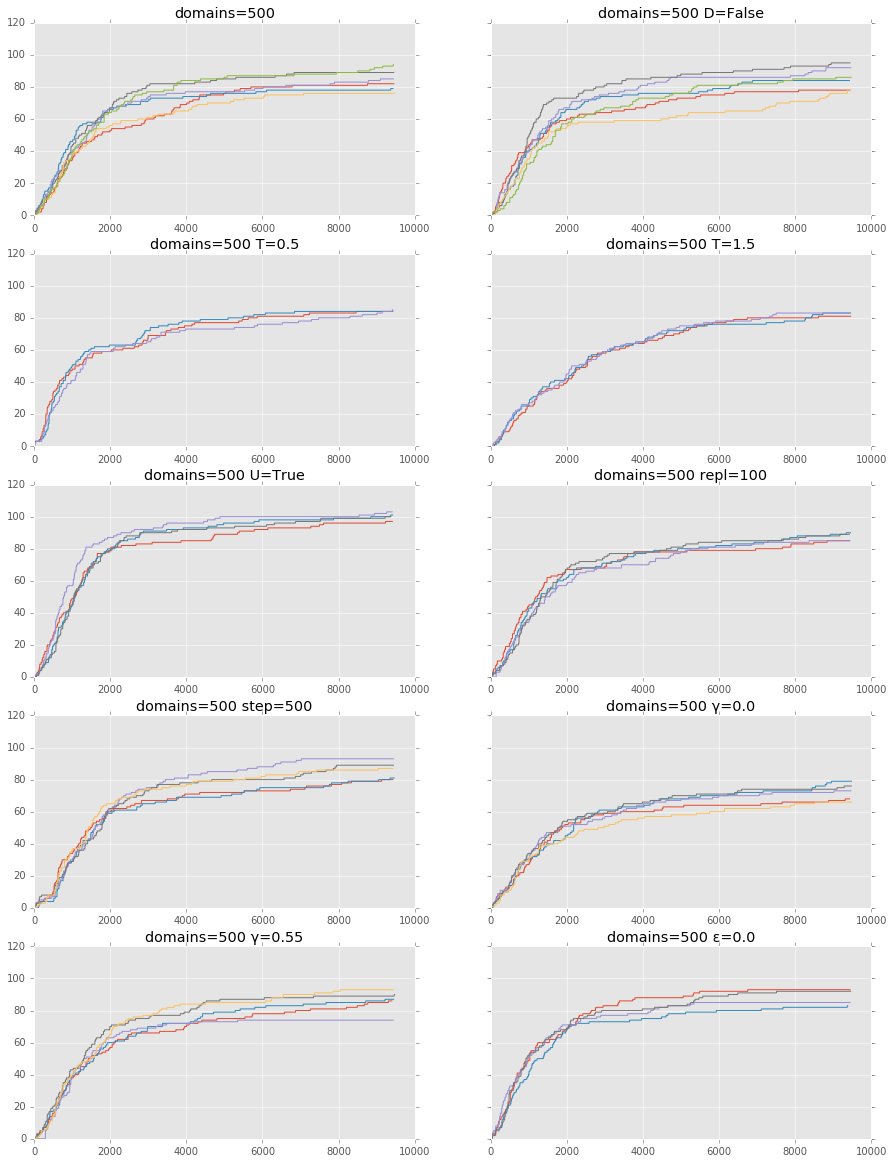

In [241]:
plot_all(groups_500, 120, 10000)

In [242]:
len(results_500)

45

In [243]:
# for meta, stats, params in results_100[:5]:
#     stats['domains_closed'].plot(figsize=(12,8))

In [244]:
groups_500.keys()

dict_keys(['domains=500', 'domains=500 γ=0.0', 'domains=500 U=True', 'domains=500 repl=100', 'domains=500 γ=0.55', 'domains=500 T=1.5', 'domains=500 T=0.5', 'domains=500 D=False', 'domains=500 step=500', 'domains=500 ε=0.0'])

In [245]:
series = [df.domains_closed for df in groups_500['domains=500']]

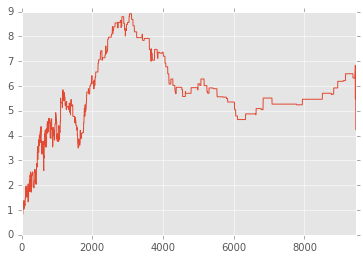

In [246]:
df = pd.DataFrame(series).T
df.std(axis=1).plot()

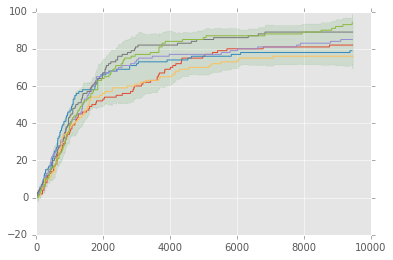

In [247]:
mstd = df.std(axis=1)
ma = df.mean(axis=1)
mmax = df.max(axis=1)
mmin = df.min(axis=1)

plt.figure()
plt.plot(df.index, df, alpha=1.0)
# plt.plot(ma.index, ma, 'k', linewidth=0.5)
# plt.plot(mmax.index, mmax, 'm', linewidth=0.5)
# plt.plot(mmin.index, mmin, 'm', linewidth=0.5)

plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='g', alpha=0.1)
# plt.fill_between(mstd.index, ma-mstd, ma+mstd, color='g', alpha=0.1)

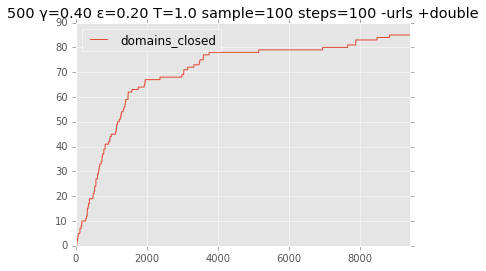

In [161]:
df = pd.DataFrame(stats)
df[['domains_closed']].plot(title=print_params(params))